In [1]:
import re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [2]:
# 1) LOAD & QUICK CHECK
df = pd.read_csv("data/ag_news_train.csv")

In [4]:
# Merge text fields (use whatever columns exist)
df['text'] = (df['title'].fillna('') + " " + df['description'].fillna('')).str.strip()


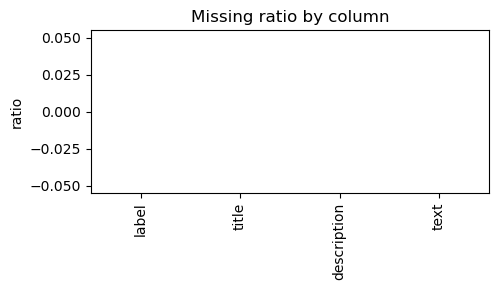

In [5]:
# --- Visualization: Missing ratio ---
plt.figure(figsize=(5,3))
(df.isnull().sum() / len(df)).plot(kind='bar')
plt.title("Missing ratio by column")
plt.ylabel("ratio")
plt.tight_layout(); plt.show()

In [6]:
# 2) HANDLE MISSING + ENCODE
df = df.dropna(subset=['label']).copy()
df['text'] = df['text'].fillna('')

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
print("Classes:", list(le.classes_))

Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


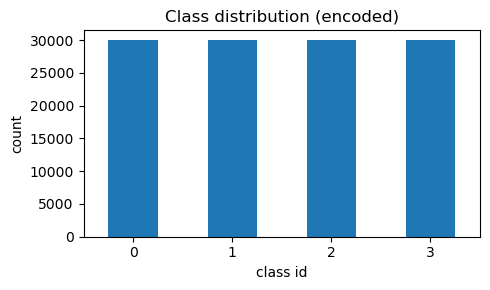

In [7]:
# --- Visualization: Class balance ---
plt.figure(figsize=(5,3))
df['label_enc'].value_counts().sort_index().plot(kind='bar', rot=0)
plt.title("Class distribution (encoded)")
plt.xlabel("class id"); plt.ylabel("count")
plt.tight_layout(); plt.show()

In [8]:
# 3) TEXT CLEANING
STOPWORDS = set([
    'the','a','an','and','or','but','if','while','is','are','was','were',
    'to','of','in','on','for','with','as','by','at','from'
])
link_re = re.compile(r"http\S+|www\.\S+")
punct_table = str.maketrans('', '', string.punctuation)
num_re = re.compile(r"\b\d+\b")

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = link_re.sub(' ', s)                 # remove links
    s = num_re.sub(' ', s)                  # remove bare numbers
    s = s.translate(punct_table)            # remove punctuation
    s = re.sub(r"\s+", " ", s).strip()
    s = " ".join(w for w in s.split() if w not in STOPWORDS)
    return s

df['text_clean'] = df['text'].apply(clean_text)

In [11]:
# 4) TRAIN/VAL SPLIT
X_train_raw, X_val, y_train_raw, y_val = train_test_split(
    df['text_clean'], df['label_enc'],
    test_size=0.16666, stratify=df['label_enc'], random_state=42
)
print("Split -> train:", len(X_train_raw), "val:", len(X_val))

Split -> train: 100000 val: 20000


In [12]:
# 5) OUTLIERS (TRAIN ONLY)
train_len = X_train_raw.apply(lambda s: len(str(s).split()))

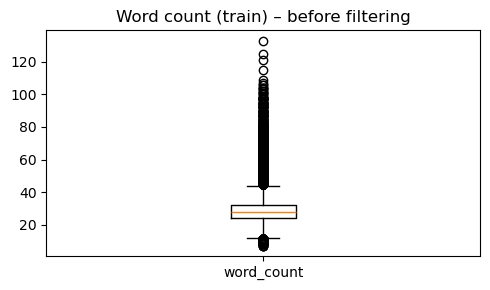

In [13]:
# --- Visualization: Boxplot of word_count (Matplotlib ≥3.9 uses tick_labels) ---
plt.figure(figsize=(5,3))
plt.boxplot([train_len], tick_labels=['word_count'])
plt.title("Word count (train) – before filtering")
plt.tight_layout(); plt.show()

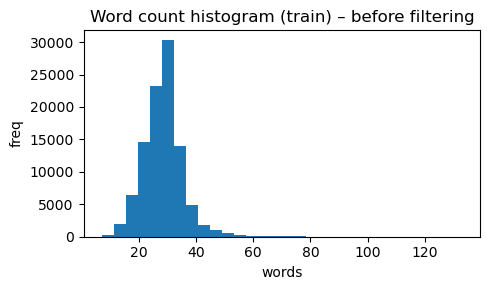

In [14]:
# --- Visualization: Histogram before ---
plt.figure(figsize=(5,3))
plt.hist(train_len, bins=30)
plt.title("Word count histogram (train) – before filtering")
plt.xlabel("words"); plt.ylabel("freq")
plt.tight_layout(); plt.show()

In [15]:
# IQR thresholds
Q1, Q3 = train_len.quantile(0.25), train_len.quantile(0.75)
IQR = Q3 - Q1
low_thr, high_thr = max(1, int(Q1 - 1.5*IQR)), int(Q3 + 1.5*IQR)
print(f"IQR thresholds: low<{low_thr}, high>{high_thr}")

keep_mask = (train_len >= low_thr) & (train_len <= high_thr)
X_train = X_train_raw[keep_mask]
y_train = pd.Series(y_train_raw).loc[X_train.index]

print("Train after outlier removal:", len(X_train), " / ", len(X_train_raw))

IQR thresholds: low<12, high>44
Train after outlier removal: 97344  /  100000


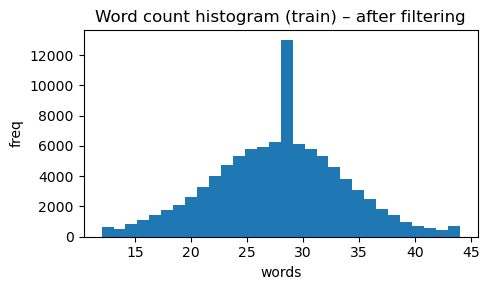

In [16]:
# --- Visualization: Histogram after ---
plt.figure(figsize=(5,3))
plt.hist(X_train.apply(lambda s: len(str(s).split())), bins=30)
plt.title("Word count histogram (train) – after filtering")
plt.xlabel("words"); plt.ylabel("freq")
plt.tight_layout(); plt.show()

In [17]:
# 6) NUMERIC FEATURES + MIN-MAX
def numeric_feats(series):
    # From cleaned text; punctuation already removed → punct_ratio≈0
    arr = []
    for s in series:
        s = str(s)
        words = s.split()
        wc = len(words)
        cc = len(s)
        avgw = (sum(len(w) for w in words)/wc) if wc>0 else 0.0
        arr.append((wc, cc, avgw, 0.0))
    return pd.DataFrame(arr, columns=['word_count','char_count','avg_word_len','punct_ratio'])

train_num_raw = numeric_feats(X_train)
val_num_raw   = numeric_feats(X_val)

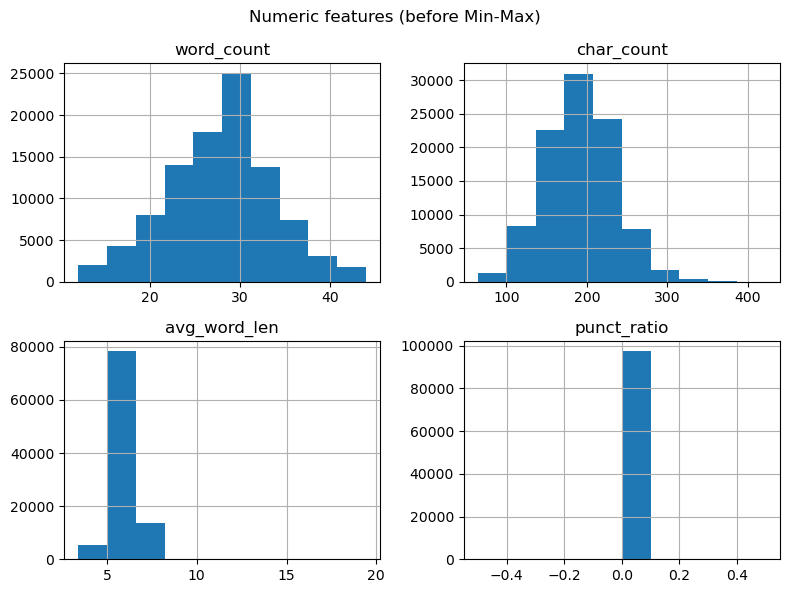

In [18]:
# Visualization: Numeric feature histograms BEFORE Min-Max ---
train_num_raw[['word_count','char_count','avg_word_len','punct_ratio']].hist(figsize=(8,6))
plt.suptitle("Numeric features (before Min-Max)")
plt.tight_layout(); plt.show()

In [19]:
# Prepare frames for ColumnTransformer
train_frame = pd.DataFrame({'text': X_train}).reset_index(drop=True).join(train_num_raw.reset_index(drop=True))
val_frame   = pd.DataFrame({'text': X_val}).reset_index(drop=True).join(val_num_raw.reset_index(drop=True))

In [20]:
# 7) TF-IDF + MIN-MAX + χ²
tfidf = TfidfVectorizer(max_features=120_000, ngram_range=(1,2), stop_words=None, lowercase=False)

ct = ColumnTransformer([
    ('tfidf', tfidf, 'text'),
    ('num', MinMaxScaler(), ['word_count','char_count','avg_word_len','punct_ratio'])
])

pipe = Pipeline([
    ('features', ct),
    ('kbest', SelectKBest(chi2, k=30_000))   # χ² Feature Selection
])

In [21]:
# Fit on TRAIN only; transform both
X_train_feat = pipe.fit_transform(train_frame, y_train)
X_val_feat   = pipe.transform(val_frame)
print("Feature shapes -> train:", X_train_feat.shape, "val:", X_val_feat.shape)

Feature shapes -> train: (97344, 30000) val: (20000, 30000)


<Figure size 600x300 with 0 Axes>

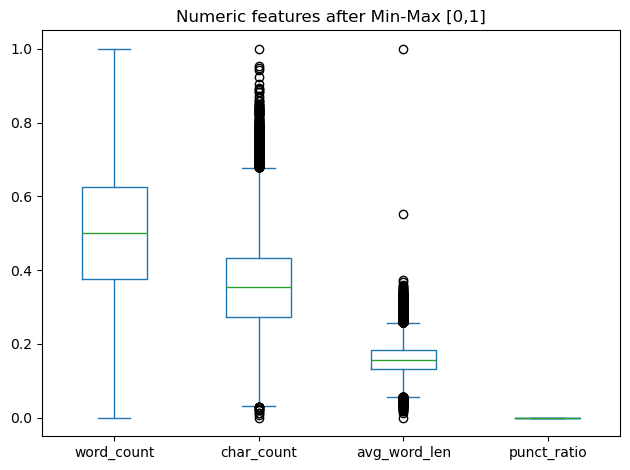

In [22]:
# Visualization: Numeric feature boxplot AFTER Min-Max ---
# (Transform numeric separately for plotting)
mm = MinMaxScaler().fit(train_num_raw)
train_num_mm = pd.DataFrame(mm.transform(train_num_raw), columns=train_num_raw.columns)
plt.figure(figsize=(6,3))
train_num_mm.plot(kind='box')
plt.title("Numeric features after Min-Max [0,1]")
plt.tight_layout(); plt.show()

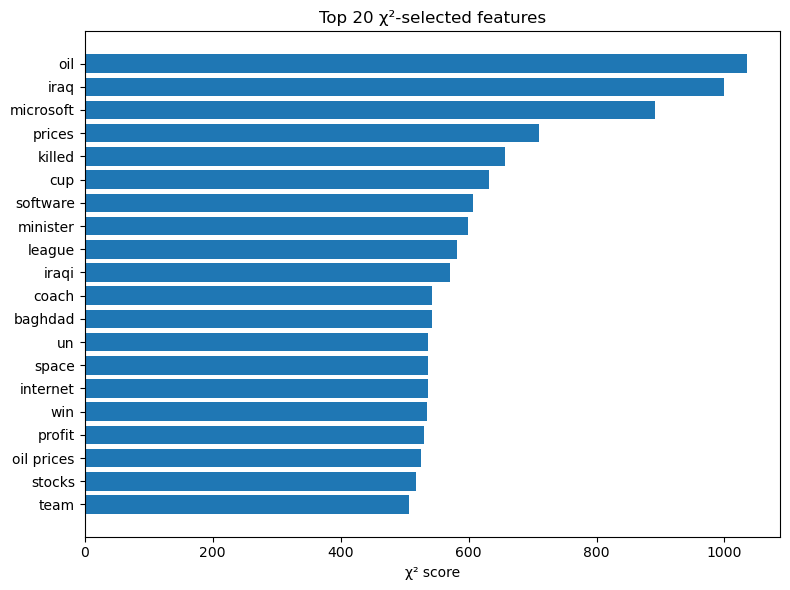

In [23]:
# Visualization: Top χ² features (overall) ---
# Build combined feature names in ColumnTransformer order: [TF-IDF..., numeric...]
tfidf_names = pipe.named_steps['features'].named_transformers_['tfidf'].get_feature_names_out()
num_names   = np.array(['word_count','char_count','avg_word_len','punct_ratio'])
combined_feature_names = np.concatenate([tfidf_names, num_names])

kbest = pipe.named_steps['kbest']
scores = kbest.scores_          # aligned to input of kbest (combined order)
# Some features can have NaN scores; replace with 0 for sorting
scores = np.nan_to_num(scores, nan=0.0)

top_idx = np.argsort(scores)[-20:]
top_feats = combined_feature_names[top_idx]
top_scores = scores[top_idx]
order = np.argsort(top_scores)

plt.figure(figsize=(8,6))
plt.barh(top_feats[order], top_scores[order])
plt.title("Top 20 χ²-selected features")
plt.xlabel("χ² score")
plt.tight_layout(); plt.show()

              precision    recall  f1-score   support

           0     0.9314    0.8988    0.9148      5000
           1     0.9464    0.9808    0.9633      5000
           2     0.8913    0.8934    0.8923      5000
           3     0.8996    0.8962    0.8979      5000

    accuracy                         0.9173     20000
   macro avg     0.9172    0.9173    0.9171     20000
weighted avg     0.9172    0.9173    0.9171     20000



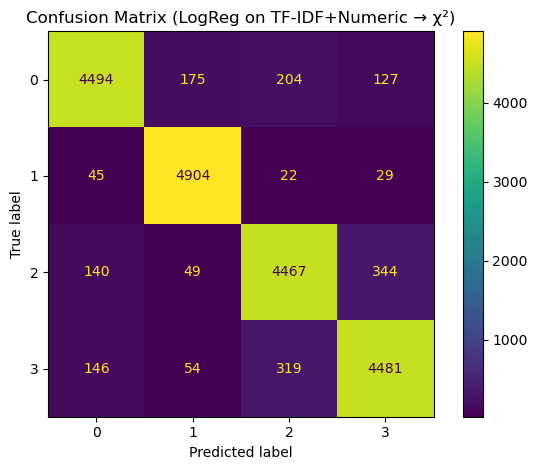


 All preprocessing complete with visuals.


In [25]:
# 8) QUICK MODEL + CONFUSION MATRIX
clf = LogisticRegression(max_iter=300, n_jobs=-1)
clf.fit(X_train_feat, y_train)
pred = clf.predict(X_val_feat)
print(classification_report(y_val, pred, digits=4))

cm = confusion_matrix(y_val, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=0)
plt.title("Confusion Matrix (LogReg on TF-IDF+Numeric → χ²)")
plt.tight_layout(); plt.show()

print("\n All preprocessing complete with visuals.")